# Setup

In [1]:
include(joinpath("..","src","setup.jl"))

datadir = joinpath("..","data","count_lengths","run_2018-11-23")

┌ Info: Recompiling stale cache file /Users/davidlittle/.julia/compiled/v1.0/Unitful/5WYj5.ji for Unitful [1986cc42-f94f-5a68-af5c-568840ba703d]
└ @ Base loading.jl:1190
┌ Warning: Package RCall does not have AxisArrays in its dependencies:
│ - If you have RCall checked out for development and have
│   added AxisArrays as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with RCall
│ Loading AxisArrays into RCall from project dependency, future warnings for RCall are suppressed.
└ @ nothing nothing:840
┌ Info: Recompiling stale cache file /Users/davidlittle/.julia/compiled/v1.0/VegaLite/lrJqi.ji for VegaLite [112f6efa-9a02-5b7d-90c0-432ed331239a]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /Users/davidlittle/.julia/compiled/v1.0/AuditoryBistabilityLE/RqG8S.ji for AuditoryBistabilityLE [7e25a372-ade5-11e8-17af-a30e5a9e2c28]
└ @ Base loading.jl:1190


┌ Info: Recompiling stale cache file /Users/davidlittle/.julia/compiled/v1.0/Feather/RgcL0.ji for Feather [becb17da-46f6-5d3c-ad1b-1c5fe96bc73c]
└ @ Base loading.jl:1190
┌ Info: Precompiling Gadfly [c91e804a-d5a3-530f-b6f0-dfbca275c004]
└ @ Base loading.jl:1192
┌ Info: Loading Cairo backend into Compose.jl
└ @ Compose /Users/davidlittle/.julia/packages/Compose/BYWXX/src/Compose.jl:161
┌ Warning: 
│ Loading Cairo into Compose from project dependency, future warnings for Compose are suppressed.
└ @ nothing nothing:840
┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/davidlittle/.julia/packages/Gadfly/ew1SM/src/mapping.jl:228
┌ Info: Recompiling stale cache file /Users/davidlittle/.julia/compiled/v1.0/PlotAxes/PgPqz.ji for PlotAxes [8b6f5f00-d239-11e8-3a24-33314b00f6b0]
└ @ Base loading.jl:1190


"../data/count_lengths/run_2018-11-23"

# TODO:
- verify the range of parameters we've selected
- plots for early results and aim 1
- plots for aim 2
- run buildup simulation
- run the sensitivity analyses
- run the factorial analysis

# Questions

Why does bistability arise with no adaptation for the scale-level? (or the object level?)

# Load data

In [2]:
params = load(joinpath(datadir,"params.jld2"),"params")
params[:pindex] = 1:size(params,1)
settings = joinpath("..","src","settings.toml")

results = []
setfile = AuditoryBistabilityLE.read_settings(settings)
for_results_in(joinpath(datadir,"data")) do entry
  # with_logger(NullLogger()) do
  #     lengths, percepts = percept_lengths(audiospect(entry["mask"],setfile),params[entry["pindex"],:],setfile)
  #     push!(results,DataFrame(length=lengths,percepts=percepts.+1,created=entry["created"],pindex=entry["pindex"]))
  # end
  
  push!(results,DataFrame(length=entry["lengths"],
                          percepts=entry["percepts"].+1, # after +1, indicates the number of streams reported, 1 or 2
                          created=entry["created"],
                          pindex=entry["pindex"])) # the parameter index (pindex = N correspondes to row N of `params`)
end
df = vcat(results...);
head(df)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


,length,percepts,created,pindex
,Float64,Int64,DateTime,Int64
1,23.3,1,2018-11-23T15:27:49.102,1
2,23.3,1,2018-11-23T15:29:06.64,1
3,23.3,1,2018-11-23T15:29:10.412,1
4,23.3,1,2018-11-23T15:29:14.095,1
5,23.3,1,2018-11-23T15:29:17.785,1
6,23.3,1,2018-11-23T15:29:21.297,1


In [7]:
sim_length = jldopen(joinpath(datadir,"data",readdir(joinpath(datadir,"data"))[1]),"r") do first_file
    last(first_file["btimes_s"])
end

47.6

In [22]:
include(joinpath(srcdir,"setup.jl"));

In [23]:
dfh = setup_human_data()
fields = [:f_c_a,:f_c_m,:f_c_σ,:s_c_a,:s_c_m,:s_c_σ,:t_c_a,:t_c_m,:t_c_σ]
progress = Progress(nrow(unique(params[fields])))
df_summary = by(@where(params,:Δf .== 6),fields) do row
    next!(progress)
    result =
        model_rms(df,params,dfh,return_parts=true,
                  f_c_a=row[1,:f_c_a], f_c_m=row[1,:f_c_m], f_c_σ = row[1,:f_c_σ],
                  s_c_a=row[1,:s_c_a], s_c_m=row[1,:s_c_m], s_c_σ = row[1,:s_c_σ],
                  t_c_a=row[1,:t_c_a], t_c_m=row[1,:t_c_m], t_c_σ = row[1,:t_c_σ])
    DataFrame([result])
end
head(df_summary)

Progress:   0%|                                         |  ETA: 0:00:35┌ Warning: Default for keyword argument "closed" has changed from :right to :left.
│ To avoid this warning, specify closed=:right or closed=:left as appropriate.
│   caller = #fit#99 at hist.jl:234 [inlined]
└ @ Core /Users/davidlittle/.julia/packages/StatsBase/NzjNi/src/hist.jl:234
Progress: 100%|█████████████████████████████████████████| Time: 0:03:60


,f_c_a,f_c_m,f_c_σ,s_c_a,s_c_m,s_c_σ,t_c_a,t_c_m,t_c_σ,rms,stream_rms,stream_mean_rms_error,length_rms
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,2.76659,4.32517,7.17643,1.20802
2,0.0,5.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1.52312,2.41741,1.90736,0.628836
3,0.0,29.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1.59399,2.04759,1.05731,1.14039
4,0.0,160.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1.59515,1.98679,-0.0587345,1.20352
5,0.0,940.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1.59535,1.99278,-0.0820686,1.19791
6,0.0,5400.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1.5914,1.99007,-0.021148,1.19273


In [24]:
function rename_levels_for(df,vals)
    df[:c_m] = NaN
    df[:c_a] = NaN
    df[:level] = "unknown"
    @byrow! df begin
        if :f_c_σ > 0 
           :level = "Peripheral"
            :c_m = :f_c_m
            :c_a = :f_c_a
        elseif :s_c_σ > 0 
            :level = "Cortical"
            :c_m = :s_c_m
            :c_a = :s_c_a
        elseif :t_c_σ > 0 
            :level = "Object"
            :c_m = :t_c_m
            :c_a = :t_c_a
        end
    end
    df[[:c_m;:c_a;:level;vals]]
end
        
DataFramesMeta.linq(::DataFramesMeta.SymbolParameter{:rename_levels}, df, vals) = :(rename_levels($df,$vals))

In [25]:
label_digits = 1
dfplot = @linq df_summary |>
    rename_levels_for([:rms, :stream_rms, :stream_mean_rms_error, :length_rms]) |>
    transform(log_a = ifelse.(iszero.(:c_a),:c_a,log.(:c_a)),
              log_m = ifelse.(iszero.(:c_m),:c_m,log.(:c_m)),
              stream_weight = :stream_rms ./ (:stream_rms .+ :length_rms)) |>
    transform(rms_str = string.(round.(:rms,digits=label_digits)),
              stream_weight_str = string.(round.(:stream_weight,digits=label_digits)),
              stream_mean_rms_error_str = string.(round.(:stream_mean_rms_error,digits=label_digits)))
              

,c_m,c_a,level,rms,stream_rms,stream_mean_rms_error,length_rms,log_a,log_m,stream_weight,rms_str,stream_weight_str,stream_mean_rms_error_str
,Float64,Float64,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,String,String,String
1,0.0,0.0,Peripheral,2.76659,4.32517,7.17643,1.20802,0.0,0.0,0.781678,2.8,0.8,7.2
2,5.0,0.0,Peripheral,1.52312,2.41741,1.90736,0.628836,0.0,1.60944,0.79357,1.5,0.8,1.9
3,29.0,0.0,Peripheral,1.59399,2.04759,1.05731,1.14039,0.0,3.3673,0.642284,1.6,0.6,1.1
4,160.0,0.0,Peripheral,1.59515,1.98679,-0.0587345,1.20352,0.0,5.07517,0.622758,1.6,0.6,-0.1
5,940.0,0.0,Peripheral,1.59535,1.99278,-0.0820686,1.19791,0.0,6.84588,0.624562,1.6,0.6,-0.1
6,5400.0,0.0,Peripheral,1.5914,1.99007,-0.021148,1.19273,0.0,8.59415,0.625258,1.6,0.6,-0.0
7,31000.0,0.0,Peripheral,1.58391,1.98578,0.246243,1.18204,0.0,10.3417,0.626861,1.6,0.6,0.2
8,170000.0,0.0,Peripheral,1.58543,1.9788,0.700926,1.19206,0.0,12.0436,0.624059,1.6,0.6,0.7
9,1.0e6,0.0,Peripheral,1.59448,1.98892,0.784121,1.20003,0.0,13.8155,0.623691,1.6,0.6,0.8


In [26]:
using Gadfly

In [27]:
scale = reverse!(colormap("RdBu",mid=(2.5-1)/2.5));


In [39]:
xvals = [0.0; log.(sort!(filter(!iszero,unique(dfplot.c_a))))];
yvals = [0.0; log.(sort!(filter(!iszero,unique(dfplot.c_m))))];

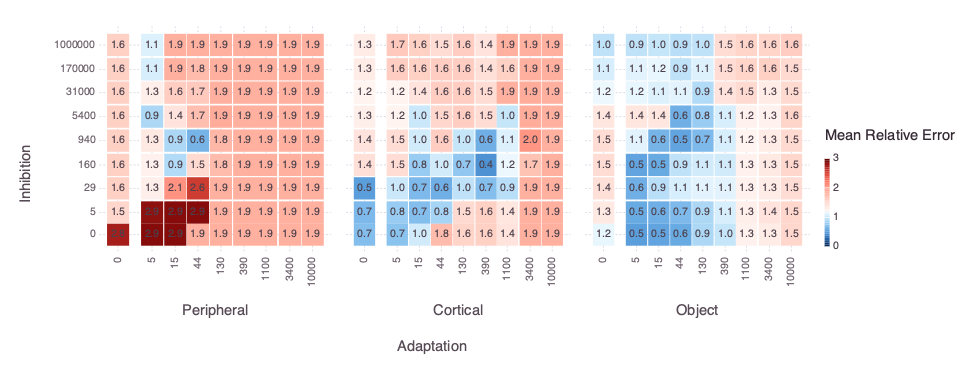

false

In [37]:
draw(PNG(10inch,4inch),plot(dfplot,x=:log_a,y=:log_m,color=:rms,xgroup=:level,label=:rms_str,
     Geom.subplot_grid(Geom.label(position=:centered),Geom.rectbin,Coord.cartesian(ymin=0,xmin=0),
                       Guide.xticks(ticks=xvals,orientation=:vertical),
                       Guide.yticks(ticks=yvals,orientation=:horizontal)),
     Guide.xlabel("Adaptation"), Guide.ylabel("Inhibition"),
     Scale.color_continuous(colormap=x -> scale[1+floor(Int,99*x)]),
     Guide.colorkey(title="Mean Relative Error"),
     Scale.x_continuous(labels=x -> iszero(x) ? "0" : string(round(Int,exp(x)))),
     Scale.y_continuous(labels=x -> iszero(x) ? "0" : string(round(Int,exp(x))))))

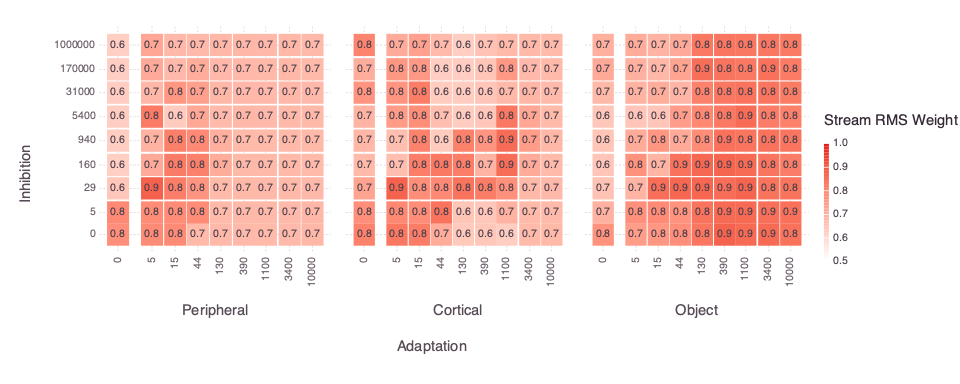

false

In [44]:
vals = [0.0; log.(dfplot[2:9,:c_m])]
draw(PNG(10inch,4inch),plot(dfplot,x=:log_a,y=:log_m,color=:stream_weight,xgroup=:level,label=:stream_weight_str,
     Geom.subplot_grid(Geom.label(position=:centered),Geom.rectbin,Coord.cartesian(ymin=0,xmin=0),
                       Guide.xticks(ticks=xvals,orientation=:vertical),
                       Guide.yticks(ticks=yvals,orientation=:horizontal)),
     Guide.xlabel("Adaptation"), Guide.ylabel("Inhibition"),
     Scale.color_continuous(minvalue=0.5,maxvalue=1,colormap=Scale.lab_gradient("white",colorant"#e41a1c")),
     Guide.colorkey(title="Stream RMS Weight"),
     Scale.x_continuous(labels=x -> iszero(x) ? "0" : string(round(Int,exp(x)))),
     Scale.y_continuous(labels=x -> iszero(x) ? "0" : string(round(Int,exp(x))))))

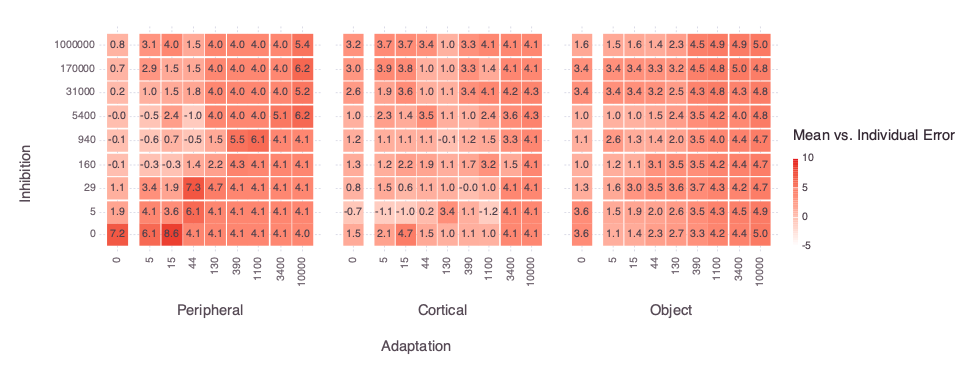

false

In [43]:
vals = [0.0; log.(dfplot[2:9,:c_m])]
draw(PNG(10inch,4inch),plot(dfplot,x=:log_a,y=:log_m,color=:stream_mean_rms_error,xgroup=:level,label=:stream_mean_rms_error_str,
     Geom.subplot_grid(Geom.label(position=:centered),Geom.rectbin,Coord.cartesian(ymin=0,xmin=0),
                       Guide.xticks(ticks=xvals,orientation=:vertical),
                       Guide.yticks(ticks=yvals,orientation=:horizontal)),
     Guide.xlabel("Adaptation"), Guide.ylabel("Inhibition"),
     Scale.color_continuous(colormap=Scale.lab_gradient("white",colorant"#e41a1c")),
     Guide.colorkey(title="Mean vs. Individual Error"),
     Scale.x_continuous(labels=x -> iszero(x) ? "0" : string(round(Int,exp(x)))),
     Scale.y_continuous(labels=x -> iszero(x) ? "0" : string(round(Int,exp(x))))))

# Peripheral-level

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Some of the frequency channels are missing.
└ @ ShammaModel /Users/davidlittle/googledrive/juliadev/ShammaModel/src/audiospect.jl:146


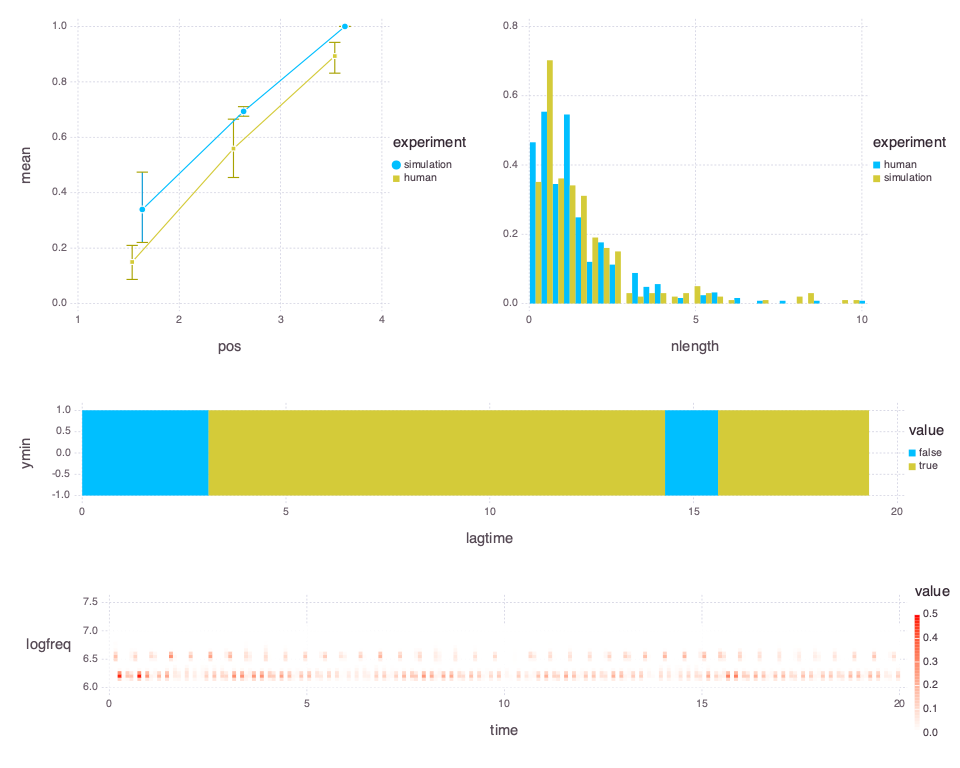

┌ Info: Stimulus is 47.999875 seconds long.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/stim.jl:43


false

In [186]:
draw(PNG(10inch,8inch),plot_fitmask(df,params,settings,f_c_a=5,f_c_m=44))

possible claim: selectivity and bistability disappears, strong "bias" or basically a single percept shown
this will show up as
- bad streaming rms
- bad lengths rms
- poor match between mean and individual rms

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Some of the frequency channels are missing.
└ @ ShammaModel /Users/davidlittle/googledrive/juliadev/ShammaModel/src/audiospect.jl:146


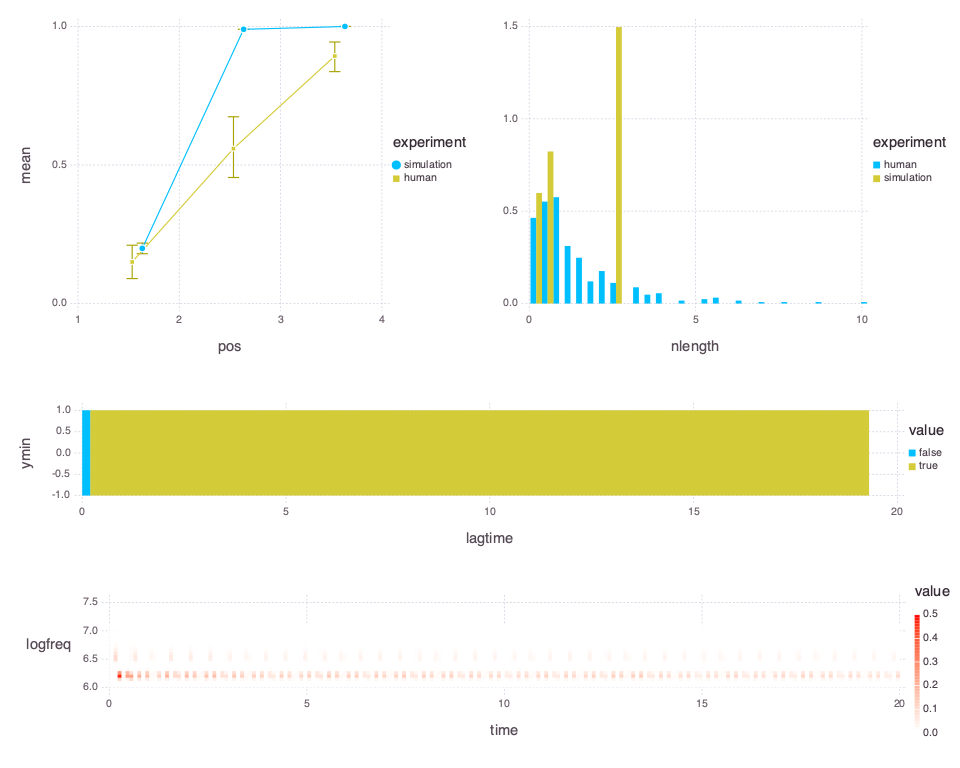

┌ Info: Stimulus is 47.999875 seconds long.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/stim.jl:43


false

In [188]:
draw(PNG(10inch,8inch),plot_fitmask(df,params,settings,f_c_a=5,f_c_m=385))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Some of the frequency channels are missing.
└ @ ShammaModel /Users/davidlittle/googledrive/juliadev/ShammaModel/src/audiospect.jl:146


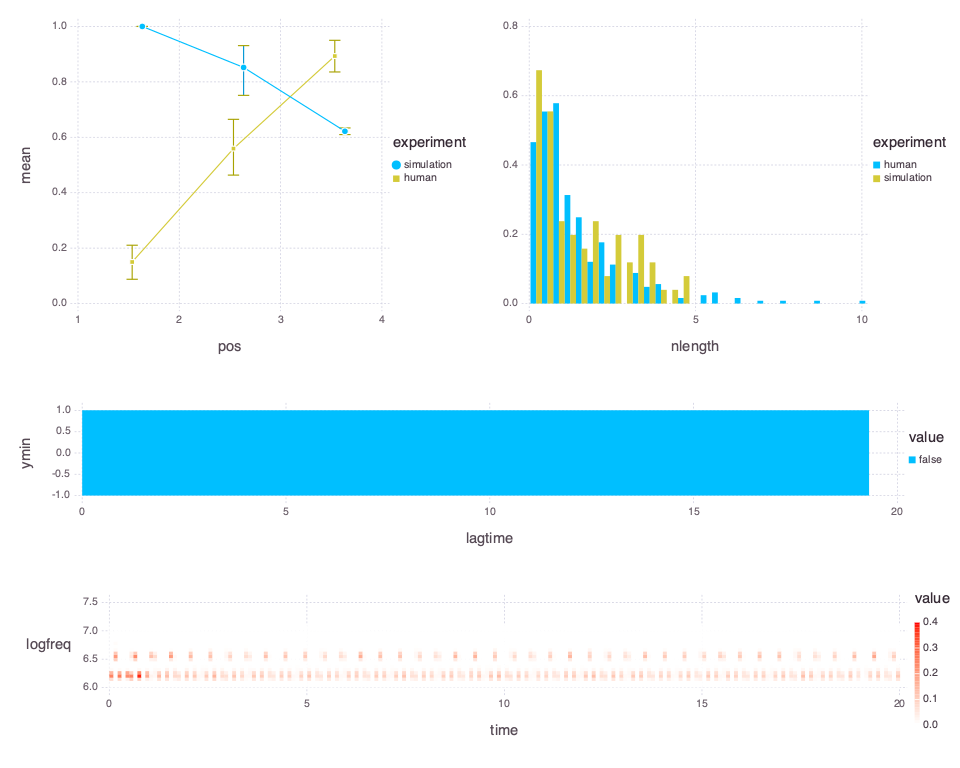

┌ Info: Stimulus is 47.999875 seconds long.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/stim.jl:43


false

In [189]:
draw(PNG(10inch,8inch),plot_fitmask(df,params,settings,f_c_a=44,f_c_m=44))

# Cortical-level

Possible claim: selectivity and bistability remains, string, ongoing bias for a given simulation. This will show up as:

- good streaming rms
- good length rms
- poor match of mean to individual rms

In [267]:
stream_rms(df,params,stream_dfh(),s_c_a=15,s_c_m=15,mean_v_ind=true)

(0.7885460752143734, 0.5791611300198476)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Some of the frequency channels are missing.
└ @ ShammaModel /Users/davidlittle/googledrive/juliadev/ShammaModel/src/audiospect.jl:146


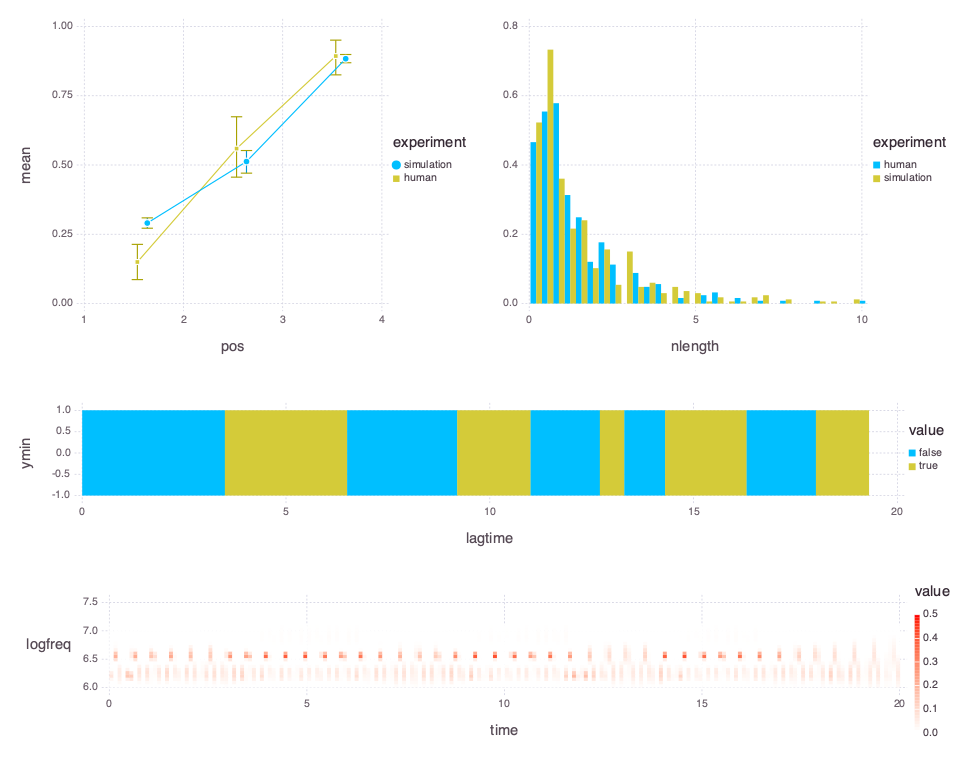

┌ Info: Stimulus is 47.999875 seconds long.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/stim.jl:43


false

In [190]:
draw(PNG(10inch,8inch),plot_fitmask(df,params,settings,s_c_a=15,s_c_m=15))

In [266]:
stream_rms(df,params,stream_dfh(),s_c_a=130,s_c_m=15,mean_v_ind=true)

(1.8388431724488226, 1.6210451699346744)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Some of the frequency channels are missing.
└ @ ShammaModel /Users/davidlittle/googledrive/juliadev/ShammaModel/src/audiospect.jl:146


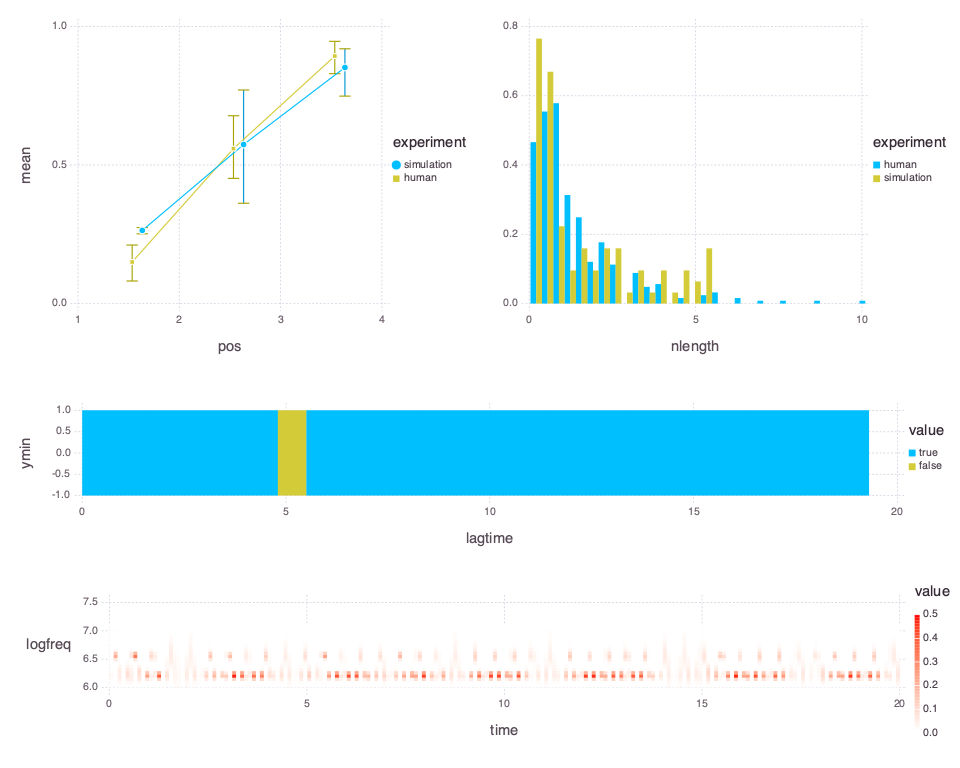

┌ Info: Stimulus is 47.999875 seconds long.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/stim.jl:43


false

In [191]:
draw(PNG(10inch,8inch),plot_fitmask(df,params,settings,s_c_a=130,s_c_m=15))

In [268]:
stream_rms(df,params,stream_dfh(),s_c_a=5,s_c_m=130,mean_v_ind=true)

(2.2816547442345994, 3.471836687006393)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Some of the frequency channels are missing.
└ @ ShammaModel /Users/davidlittle/googledrive/juliadev/ShammaModel/src/audiospect.jl:146


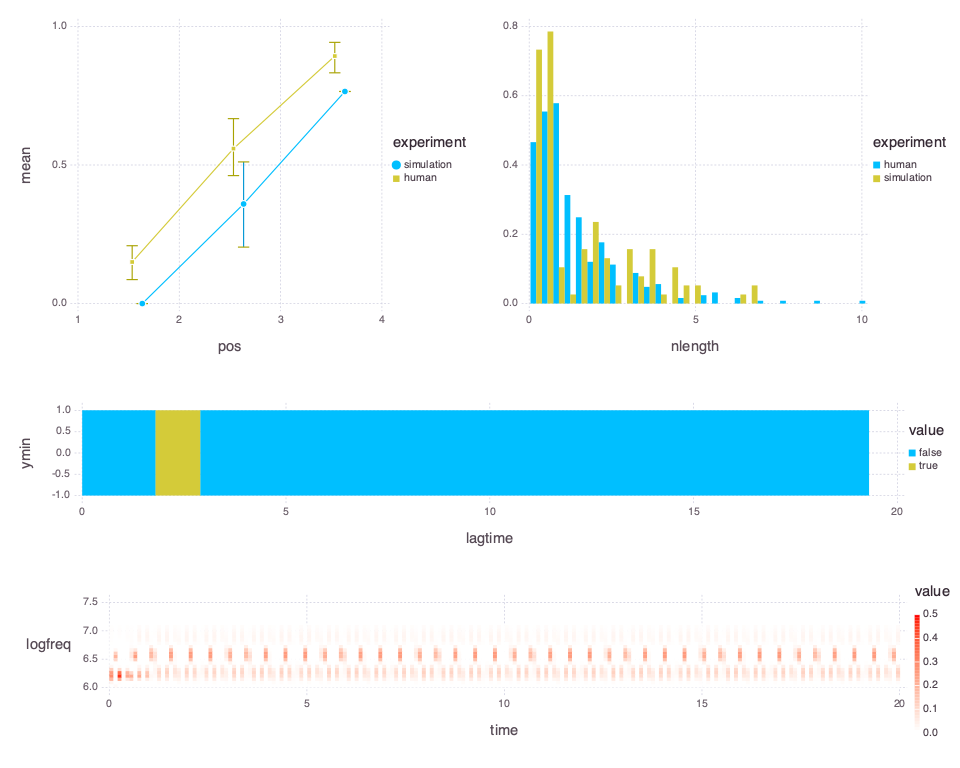

┌ Info: Stimulus is 47.999875 seconds long.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/stim.jl:43


false

In [192]:
draw(PNG(10inch,8inch),plot_fitmask(df,params,settings,s_c_a=5,s_c_m=130))

# Object-level

In [ ]:
possible claim: bistability remains, selectivity reduced at offset values

- poor streaming rms
- good length rms
- good match of mean to individual rms

Possible claim: selectivity and bistability remains, string, ongoing bias for a given simulation. This will show up as:

- good streaming rms
- good length rms
- poor match of mean to individual rms

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Some of the frequency channels are missing.
└ @ ShammaModel /Users/davidlittle/googledrive/juliadev/ShammaModel/src/audiospect.jl:146


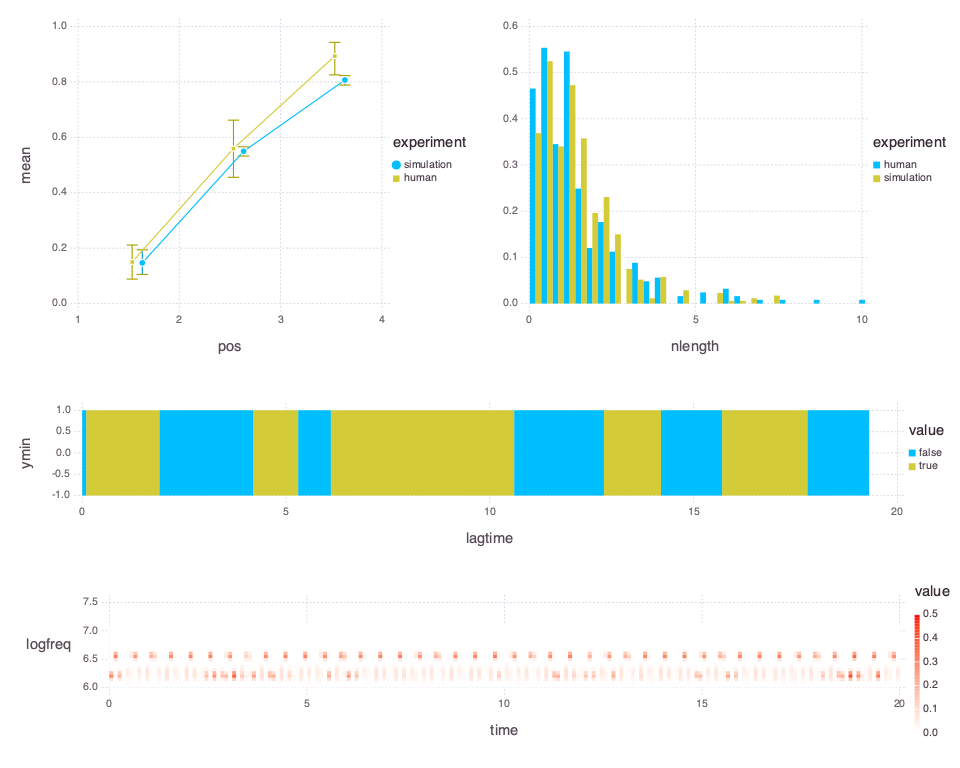

┌ Info: Stimulus is 47.999875 seconds long.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/stim.jl:43


false

In [324]:
draw(PNG(10inch,8inch),plot_fitmask(df,params,settings,t_c_a=5,t_c_m=130))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Some of the frequency channels are missing.
└ @ ShammaModel /Users/davidlittle/googledrive/juliadev/ShammaModel/src/audiospect.jl:146


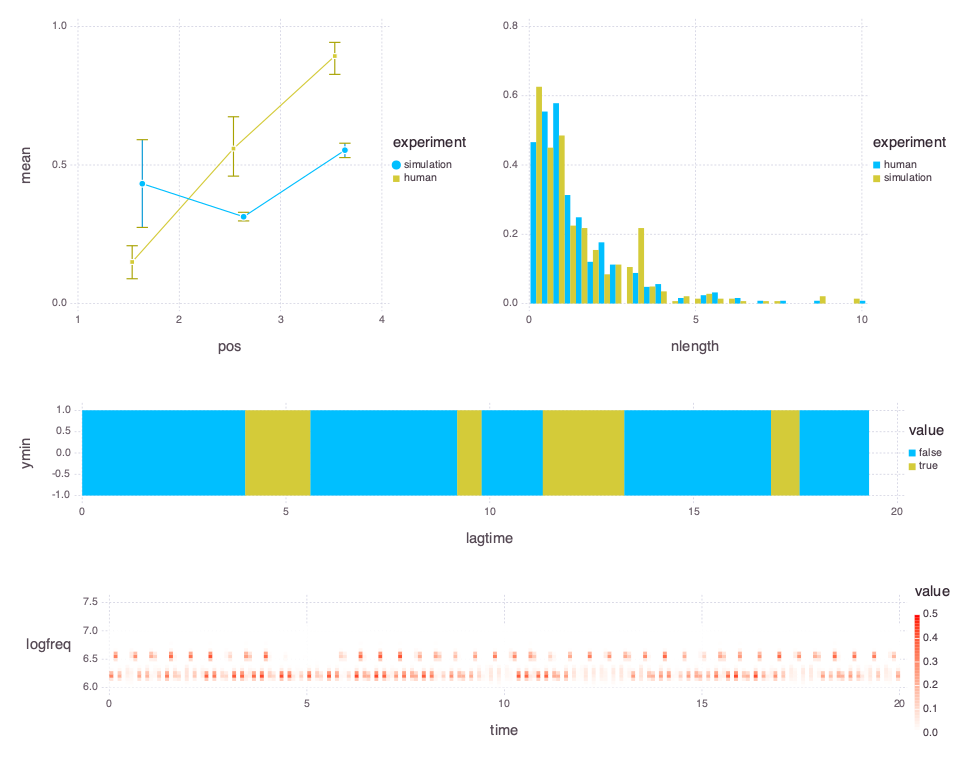

┌ Info: Stimulus is 47.999875 seconds long.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/stim.jl:43


false

In [195]:
draw(PNG(10inch,8inch),plot_fitmask(df,params,settings,t_c_a=1141,t_c_m=1141))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Some of the frequency channels are missing.
└ @ ShammaModel /Users/davidlittle/googledrive/juliadev/ShammaModel/src/audiospect.jl:146


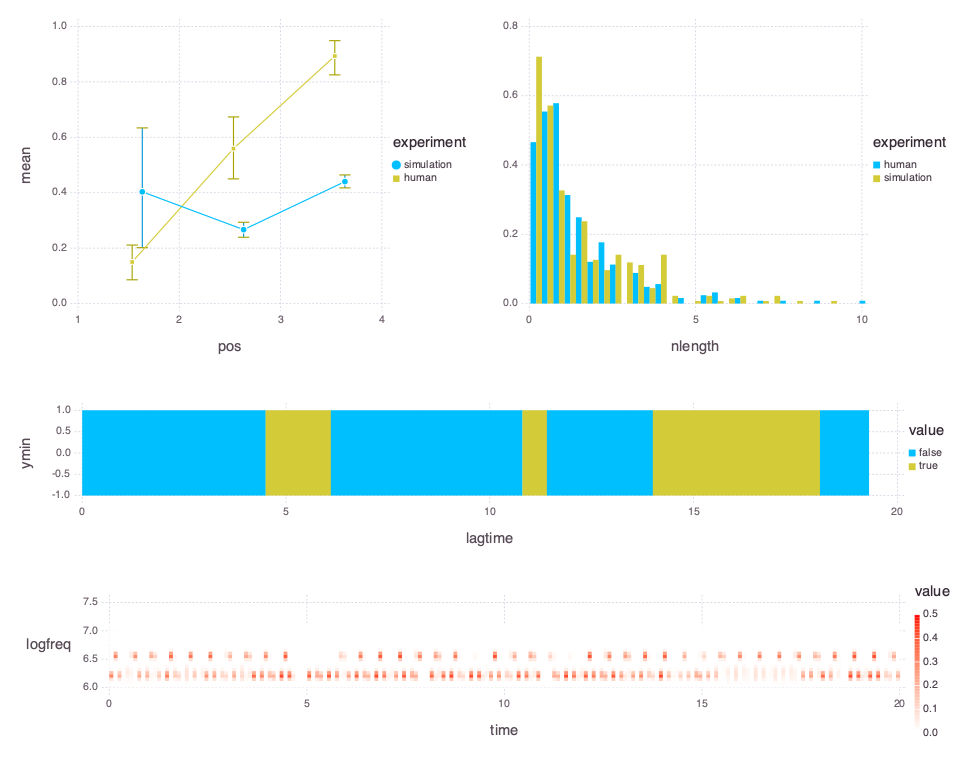

┌ Info: Stimulus is 47.999875 seconds long.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/stim.jl:43


false

In [197]:
draw(PNG(10inch,8inch),plot_fitmask(df,params,settings,t_c_a=10000,t_c_m=5))

# Count

In [ ]:
df_stim_rate = @linq df_summary |>
  where(:Δf .== 6) |>
  select(:f_c_σ,:f_c_a,:f_c_m,:s_c_σ,:s_c_a,:s_c_m,:t_c_σ,:t_c_a,:t_c_m,:stim_rate) |>
  rename_levels_for(:stim_rate);

In [ ]:
df_stim_rate |>
  @vlplot(:rect, width=300, height=300,
          title={text="Stimulus Rate",fontSize=18},
          column={field=:level, typ="nominal", sort=["Peripheral", "Cortical", "Object"]},
          x={field=:c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field=:stim_rate, aggregate="mean", typ="quantitative", 
                 legend={title="Stimuli / Second"}},
          config={range={heatmap={scheme="viridis"}}})

# Thoughts

This is interesting; the variance in the human data is greater (might suggest multiple sources, consistnet with earlier reports).

That said, it is really distracting from the point I'm trying to caputre at this stage of the analysis. I can image this plot going somewhere else... OR
normalizing by the variance in some way, so that we can determine the extent to which we can match that... for the moment that seems like a reasonable standard.

In [ ]:
selection = @where(params,(abs.(:f_c_m .- 18) .< 1) .& (abs.(:f_c_a .- 5) .< 1) .& (:Δf .== 6))[:pindex][1]

In [ ]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:nlength, bin={step=0.1}}, y="count()",
           color={field=:percepts, typ="nominal"})

In [ ]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

In [ ]:
using PlotAxes

In [ ]:
rplot(bandwidth_ratio(AuditoryBistabilityLE.decompress(masks[1])[10s .. 30s],audiospect_stimulus(params[selection,:],settings)[10s .. 30s,0.4kHz .. 1.2kHz],settings)[1])

In [ ]:
selection = @where(params,(abs.(:f_c_m .- 18) .< 1) .& (abs.(:f_c_a .- 11) .< 1) .& (:Δf .== 6))[:pindex][1]

In [ ]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=0.5}}, y="count()",
           color={field=:percepts, typ="nominal"})

In [ ]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1])[10s .. 30s])

In [ ]:
selection = @where(params,(abs.(:f_c_m .- 100) .< 1) .& (abs.(:f_c_a .- 5) .< 1) .& (:Δf .== 6))[:pindex][1]

In [ ]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=1.0}}, y="count()",
           color={field=:percepts, typ="nominal"})

In [ ]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1])[10s .. 30s])

In [ ]:
selection = @where(params,(abs.(:s_c_m .- 56) .< 1) .& (abs.(:s_c_a .- 11) .< 1) .& (:Δf .== 6))[:pindex][1]

In [ ]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=0.5}}, y="count()", column=:percepts,
           color={field=:percepts, typ="nominal"})

In [ ]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1])[25s .. 35s])

In [ ]:
selection = @where(params,(abs.(:s_c_m .- 32) .< 1) .& (abs.(:s_c_a .- 5) .< 1) .& (:Δf .== 6))[:pindex][1]

In [ ]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:nlength, bin={step=0.1}}, y="count()",
           color={field=:percepts, typ="nominal"})

In [ ]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1])[25s .. 35s])

In [ ]:
rplot(bandwidth_ratio(AuditoryBistabilityLE.decompress(masks[1])[25s .. 35s],audiospect_stimulus(params[selection,:],settings)[25s .. 35s,0.4kHz .. 1.2kHz],settings)[1])

In [ ]:
selection = @where(params,(abs.(:t_c_m .- 18) .< 1) .& (abs.(:t_c_a .- 56) .< 1) .& (:Δf .== 6))[:pindex][1]

In [ ]:
@where(df,(:pindex .== selection) .& (:length .< 20))

In [ ]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=0.5}}, y="count()",
           color={field=:percepts, typ="nominal"})

In [ ]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1]))

In [ ]:
@where(df,:pindex .== selection)

In [ ]:
selection = @where(params,(abs.(:t_c_m .- 18) .< 1) .& (abs.(:t_c_a .- 56) .< 1) .& (:Δf .== 6))[:pindex][1]

In [ ]:
# NEXT STEP: get new bandwidth_ratio parameters working, and test them out

In [ ]:
params_dict = Dict(k => params[selection,k] for k in names(params))
result = bistable_model(35,params_dict,joinpath("..","src","settings.toml"),interactive=true);

In [ ]:
result.percepts.counts

In [ ]:
rplot(result.primary_source)

In [ ]:
rplot(result.percepts.ratio)

In [ ]:
freqs(result.input[:,400Hz .. 1.2kHz])

In [ ]:
params_dict = Dict(k => params[selection,k] for k in names(params))
params_dict[:Δf] = 3
result = bistable_model(35,params_dict,joinpath("..","src","settings.toml"),interactive=true);

In [ ]:
result.percepts.counts

In [ ]:
rplot(result.percepts.ratio)

In [ ]:
rplot(result.primary_source)

In [ ]:
params_dict = Dict(k => params[selection,k] for k in names(params))
params_dict[:Δf] = 12
result = bistable_model(35,params_dict,joinpath("..","src","settings.toml"),interactive=true);

In [ ]:
result.percepts.counts

In [ ]:
rplot(result.percepts.ratio)

In [ ]:
rplot(result.primary_source)